In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import torch
from tqdm.notebook import tqdm, trange
from norse.torch.module.lif import LIFRecurrentCell
from norse.torch import LICell

In [3]:
import tonic
import torchvision

transform = tonic.transforms.Compose(
    [
        tonic.transforms.ToSparseTensor(merge_polarities=True),
    ]
)

download = True
trainset = tonic.datasets.POKERDVS(save_to='../data', download=download, train=True)
testset = tonic.datasets.POKERDVS(save_to='../data', download=download, transform=transform, train=False)

Using downloaded and verified file: ../data/pips_train.tar.gz
Extracting ../data/pips_train.tar.gz to ../data
Using downloaded and verified file: ../data/pips_test.tar.gz
Extracting ../data/pips_test.tar.gz to ../data


In [20]:
len(trainset)

48

In [41]:
trainset.ordering

'txyp'

In [42]:
trainset[0][0][4]

array([205.,   7.,  12.,   0.])

In [21]:
events = trainset[0][0]
events.shape

(2599, 4)

In [22]:
trainset.classes

['cl', 'he', 'di', 'sp']

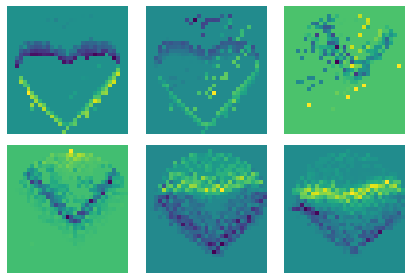

In [23]:
tonic.utils.plot_event_grid(events, trainset.ordering, axis_array=(2, 3))

In [24]:
trainset.sensor_size

(35, 35)

In [9]:
trainset.transform = transform

BATCH_SIZE = 4

train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    collate_fn=tonic.utils.pad_tensors,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    collate_fn=tonic.utils.pad_tensors,
    shuffle=False,
)

In [10]:
class SimpleSNN(torch.nn.Module):
    def __init__(self, input_features: int, hidden_features: int, output_features: int, dt):
        """
        input_features (int): height x width
        """
        super(SimpleSNN, self).__init__()

        self.l1 = LIFRecurrentCell(input_features, hidden_features, dt=dt)
        self.linear = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell(dt=dt)

        self.input_features = input_features

    def forward(self, x):
        seq_length, batch_size, _, _, _ = x.shape

        l1_state = None
        out = None

        l1_voltages = []
        out_voltages = []

        for seq in range(seq_length):
            inp = x.to_dense()[seq, :, :, :].view(-1, self.input_features)

            voltage, l1_state = self.l1(inp, l1_state)
            l1_voltages.append(voltage)

            linear_out = self.linear(voltage)

            voltage, out = self.out(linear_out, out)

            out_voltages.append(voltage)

        return torch.stack(out_voltages)

In [11]:
def decode(x):
    x, _ = torch.max(x, 1)
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y


class Model(torch.nn.Module):
    def __init__(self, snn: SimpleSNN):
        super(Model, self).__init__()
        self.snn = snn
        self.decoder = decode

    def forward(self, x):
        x = self.snn(x)
        log_p_y = self.decoder(x)
        return log_p_y

In [28]:
LR = 0.002

snn = SimpleSNN(35 * 35, 100, 4, 1e-6)
model = Model(snn)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [29]:
EPOCHS = 5  # Increase this number for better performance


def train(model, train_loader, optimizer, epoch, max_epochs):
    model.train()
    losses = []
    for (data, target) in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    return losses, mean_loss


training_losses = []
mean_losses = []

for epoch in trange(EPOCHS):
    training_loss, mean_loss = train(
        model, train_loader, optimizer, epoch, max_epochs=EPOCHS
    )

    training_losses += training_loss
    mean_losses.append(mean_loss)

    path = f"../data/model_li/snn_epoch_{epoch}.pth"
    torch.save(model.state_dict(), path)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [15]:
snn = SimpleSNN(35 * 35, 100, 4, 1e-6)
model = Model(snn)
model.load_state_dict("../data/norse_tutorial_model/model_epoch_4.pth")

AttributeError: 'str' object has no attribute 'copy'

In [14]:
model_dict = torch.load('../data/norse_tutorial_model/model_epoch_4.pth')

In [6]:
model

OrderedDict([('snn.l1.input_weights',
              tensor([[ 0.1794, -0.0728,  0.3096,  ..., -0.0262, -0.0662,  0.2231],
                      [ 0.1744,  0.1430,  0.0771,  ..., -0.1205,  0.2236,  0.1661],
                      [-0.0514, -0.0562,  0.0787,  ..., -0.1206,  0.3038, -0.0591],
                      ...,
                      [-0.1746,  0.0274,  0.1406,  ..., -0.0428, -0.1830, -0.1080],
                      [-0.0223, -0.0677,  0.1295,  ..., -0.0016, -0.1941,  0.0792],
                      [-0.0198,  0.1578,  0.1029,  ..., -0.0913, -0.1683,  0.0422]])),
             ('snn.l1.recurrent_weights',
              tensor([[ 0.0000,  0.1317, -0.0573,  ...,  0.0068,  0.0968, -0.1231],
                      [-0.0333,  0.0000,  0.0830,  ...,  0.1568, -0.1215, -0.0185],
                      [ 0.0842, -0.0362,  0.0000,  ...,  0.0882,  0.0507,  0.0523],
                      ...,
                      [ 0.0563, -0.0489, -0.0902,  ...,  0.0000, -0.2355, -0.2430],
                      [

In [30]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in tqdm(test_loader):
            output = model(data)
            test_loss += torch.nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

    return test_loss, accuracy

In [31]:
loss, acc = test(model, test_loader)

  0%|          | 0/5 [00:00<?, ?it/s]

In [32]:
acc

25.0